In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ======================
# 1. Install dependencies
# ======================
!pip install torch torchvision tqdm


In [3]:
import torch
import torch.nn as nn
import os
import cv2
import torch
import random
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
# ============================================================
# 0️⃣  Device setup
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")


🔧 Using device: cuda


In [5]:
# ============================================================
# 2. MesoInception-4 (Frame-level CNN)
# ============================================================

class MesoInception4(nn.Module):
    def __init__(self):
        super(MesoInception4, self).__init__()

        def InceptionModule(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels//2, kernel_size=1, padding=0),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels//2, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.incept1 = InceptionModule(8, 16)
        self.incept2 = InceptionModule(16, 32)

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(32*64*64, 256)  # assuming 256x256 input
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.incept1(x)
        x = self.incept2(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        return x  # feature vector for each frame


In [6]:
# ============================================================
# 2b️⃣  Frequency-Domain Model (FFT-based)
# ============================================================

class FrequencyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
          nn.Conv2d(3, 16, 3, stride=2, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Conv2d(16, 32, 3, stride=2, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.AdaptiveAvgPool2d((8, 8))
      )
        self.fc = nn.Linear(32 * 8 * 8, 128)

    def forward(self, x):
        # Convert each frame to frequency domain
        fft = torch.fft.fft2(x)
        fft_mag = torch.abs(fft)
        fft_mag = torch.log1p(fft_mag)
        fft_mag = fft_mag / (torch.max(fft_mag) + 1e-8)
        out = self.features(fft_mag)
        out = out.view(out.size(0), -1)
        return self.fc(out)


In [7]:
# ============================================================
# 3️⃣  Temporal Transformer (ViT-style)
# ============================================================

class TemporalTransformer(nn.Module):
    def __init__(self, feature_dim=256, num_heads=4, num_layers=2, ff_mult=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
          d_model=feature_dim,
          nhead=num_heads,
          dim_feedforward=feature_dim * ff_mult,
          activation='gelu',
          batch_first=True,
          dropout=0.2
      )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, feature_dim))
        self.fc_out = nn.Linear(feature_dim, 1)

    def forward(self, x):
        B = x.shape[0]
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.transformer(x)
        cls_output = x[:, 0]
        return self.fc_out(cls_output)


In [8]:
# ============================================================
# 4️⃣  Combine models → DeepfakeDetectorEnsemble
# ============================================================

class DeepfakeDetectorEnsemble(nn.Module):
    def __init__(self):
        super().__init__()
        self.frame_encoder = MesoInception4()
        self.freq_encoder = FrequencyNet()
        # Merge frame (256) + freq (128) features → 384
        self.fc_merge = nn.Linear(384, 256)
        self.temporal_encoder = TemporalTransformer(feature_dim=256)

    def forward(self, x):
        # x: (B, T, 3, H, W)
        B, T, C, H, W = x.shape
        features = []
        for t in range(T):
            frame = x[:, t]
            f_spatial = self.frame_encoder(frame)  # 256-dim
            f_freq = self.freq_encoder(frame)      # 128-dim
            f_combined = torch.cat([f_spatial, f_freq], dim=1)
            f_combined = self.fc_merge(f_combined)
            features.append(f_combined.unsqueeze(1))
        features = torch.cat(features, dim=1)  # (B, T, 256)
        return self.temporal_encoder(features)


In [17]:

# ============================================================
# 5️⃣  Dataset that reads video clips (2 sec each)
# ============================================================

class VideoClipDataset(Dataset):
    """
    Assumes directory structure:
      dataset_root/
         real/
            vid1.mp4
            vid2.mp4
         fake/
            vid3.mp4
    """
    def __init__(self, root, frames_per_clip=30, transform=None):
        self.root = root
        self.classes = ["real", "fake"]
        self.videos = []
        for cls in self.classes:
            folder = os.path.join(root, cls)
            for v in os.listdir(folder):
                if v.endswith(".mp4") or v.endswith(".avi"):
                    self.videos.append((os.path.join(folder, v), 0 if cls=="real" else 1))
        self.frames_per_clip = frames_per_clip
        self.transform = transform or transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
      path, label = self.videos[idx]
      cap = cv2.VideoCapture(path)
      frames = []
      total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      step = max(total_frames // self.frames_per_clip, 1)
      for i in range(0, total_frames, step):
          ret, frame = cap.read()
          if not ret:
              break
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          frame = Image.fromarray(frame)
          frame = self.transform(frame)
          frames.append(frame)
          if len(frames) >= self.frames_per_clip:
              break
      cap.release()

      # --- ✅ Ensure fixed length ---
      if len(frames) < self.frames_per_clip:
          # Repeat last frame to pad up to required length
          while len(frames) < self.frames_per_clip:
              frames.append(frames[-1])
      elif len(frames) > self.frames_per_clip:
          # Truncate extra frames if any
          frames = frames[:self.frames_per_clip]

      frames = torch.stack(frames)  # (T, 3, 256, 256)
      return frames, torch.tensor([label], dtype=torch.float32)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    classification_report
)


In [26]:
# ============================================================
# 6️⃣  Training and evaluation
# ============================================================

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for clips, labels in tqdm(loader, desc="Training", leave=False):
        clips, labels = clips.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(clips).squeeze(1)
        labels = labels.squeeze(1)          # ✅ fix shape
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * clips.size(0)
        pred_labels = (preds > 0.5).long()
        correct += (pred_labels == labels.long()).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total


def evaluate_full(model, loader, criterion, device, class_names=["real", "fake"], verbose=True):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for clips, labels in tqdm(loader, desc="Eval", leave=False):
            clips, labels = clips.to(device), labels.to(device)
            preds = model(clips).squeeze(1)
            probs = torch.sigmoid(preds)
            labels = labels.squeeze(1)
            loss = criterion(preds, labels)
            total_loss += loss.item() * clips.size(0)

            pred_labels = (probs > 0.5).long()
            correct += (pred_labels == labels.long()).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(pred_labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / total
    acc = correct / total

    # --- Compute metrics ---
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=2)

    if verbose:
        print("\n📊 Classification Report:\n")
        print(report)
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print("\nConfusion Matrix:\n", cm)

        # --- Confusion Matrix Heatmap ---
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="black")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

    return avg_loss, acc, precision, recall, f1, roc_auc, cm, report



In [11]:
# ============================================================
#  🔹 Unzip dataset from Google Drive and prepare
# ============================================================

import zipfile
import os

zip_path = '/content/drive/MyDrive/ee604_project/frames.zip'  # <-- change this to your actual zip name
extract_dir = '/content/drive/MyDrive/ee604_project/frames_dataset'   # folder where it'll extract

# Unzip only if not already extracted
if not os.path.exists(extract_dir):
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✅ Extraction complete.")
else:
    print("✅ Dataset already extracted.")

# Update your dataset root to the extracted folder
data_root = '/content/drive/MyDrive/ee604_project/frames_dataset/frames'


✅ Dataset already extracted.


In [12]:
# ============================================================
#  🔹 Dynamic Split for VIDEO dataset (train / val / test)
# ============================================================

import torch, random
from torch.utils.data import DataLoader, SubsetRandomSampler

# ✅ data_root is already defined above in your unzip section:
# data_root = extract_dir

# Create dataset from extracted folder
full_dataset = VideoClipDataset(root=data_root, frames_per_clip=30)

# --- Split ratios ---
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
num_samples = len(full_dataset)
indices = list(range(num_samples))
random.shuffle(indices)

train_end = int(train_ratio * num_samples)
val_end = int((train_ratio + val_ratio) * num_samples)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(full_dataset, batch_size=2, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(full_dataset, batch_size=2, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(full_dataset, batch_size=2, sampler=test_sampler, num_workers=2)

print(f"✅ Loaded {len(train_indices)} train, {len(val_indices)} val, and {len(test_indices)} test videos from {data_root}")


✅ Loaded 1840 train, 394 val, and 395 test videos from /content/drive/MyDrive/ee604_project/frames_dataset/frames


In [28]:
# ============================================================
# 7️⃣  Train!
# ============================================================

def train_deepfake_detector(data_root, epochs=5, batch_size=2, lr=1e-4, frames_per_clip=30):

    model = DeepfakeDetectorEnsemble().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val = 0.0
    save_path = os.path.join(data_root, "best_transformer_model.pth")

    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_prec, val_rec, val_f1, val_roc, val_cm, val_report = evaluate_full(model, val_loader, criterion, device)
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | ROC-AUC: {val_roc:.4f}")

        with open("val_report.txt", "w") as f:
          f.write(val_report)
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ Model saved: {save_path}")

    print(f"Training complete. Best Val Acc: {best_val:.4f}")
    return model



Epoch 1/10


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_


📊 Classification Report:

              precision    recall  f1-score   support

        real       0.38      1.00      0.55       151
        fake       0.00      0.00      0.00       243

    accuracy                           0.38       394
   macro avg       0.19      0.50      0.28       394
weighted avg       0.15      0.38      0.21       394

Accuracy: 0.3832
Precision: 0.0000 | Recall: 0.0000 | F1-score: 0.0000
ROC AUC: 0.5625

Confusion Matrix:
 [[151   0]
 [243   0]]


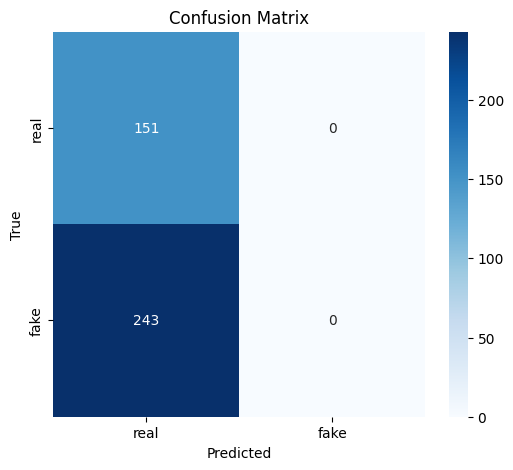

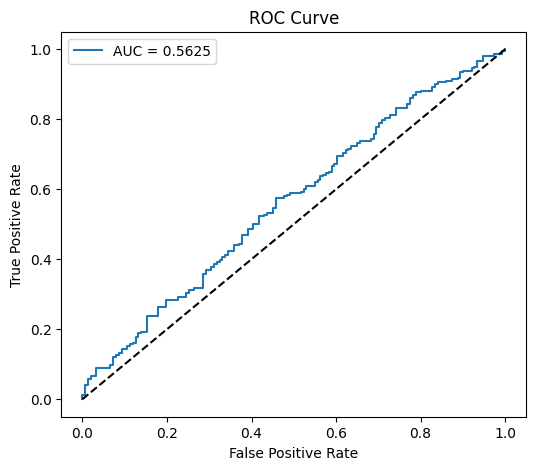

Val   Loss: 0.6972 | Acc: 0.3832 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | ROC-AUC: 0.5625
Train Loss: 0.7086 | Acc: 0.4875
Val   Loss: 0.6972 | Acc: 0.3832
✅ Model saved: /content/drive/MyDrive/ee604_project/frames_dataset/frames/best_transformer_model.pth

Epoch 2/10



📊 Classification Report:

              precision    recall  f1-score   support

        real       0.00      0.00      0.00       151
        fake       0.62      1.00      0.76       243

    accuracy                           0.62       394
   macro avg       0.31      0.50      0.38       394
weighted avg       0.38      0.62      0.47       394

Accuracy: 0.6168
Precision: 0.6168 | Recall: 1.0000 | F1-score: 0.7630
ROC AUC: 0.6109

Confusion Matrix:
 [[  0 151]
 [  0 243]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


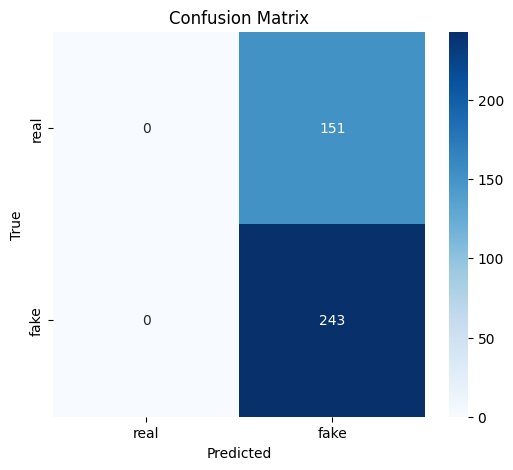

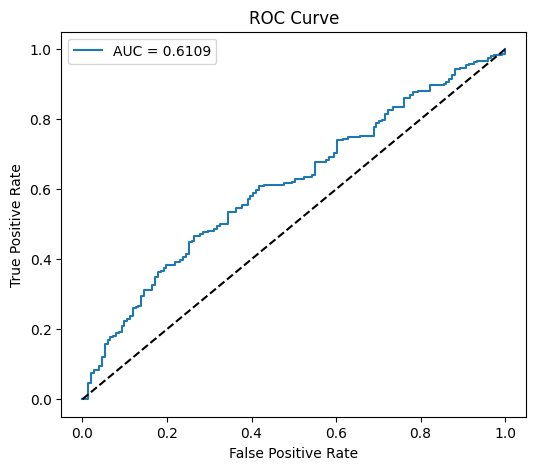

Val   Loss: 0.6665 | Acc: 0.6168 | F1: 0.7630 | Precision: 0.6168 | Recall: 1.0000 | ROC-AUC: 0.6109
Train Loss: 0.6871 | Acc: 0.4815
Val   Loss: 0.6665 | Acc: 0.6168
✅ Model saved: /content/drive/MyDrive/ee604_project/frames_dataset/frames/best_transformer_model.pth

Epoch 3/10


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Classification Report:

              precision    recall  f1-score   support

        real       0.00      0.00      0.00       151
        fake       0.62      1.00      0.76       243

    accuracy                           0.62       394
   macro avg       0.31      0.50      0.38       394
weighted avg       0.38      0.62      0.47       394

Accuracy: 0.6168
Precision: 0.6168 | Recall: 1.0000 | F1-score: 0.7630
ROC AUC: 0.6194

Confusion Matrix:
 [[  0 151]
 [  0 243]]


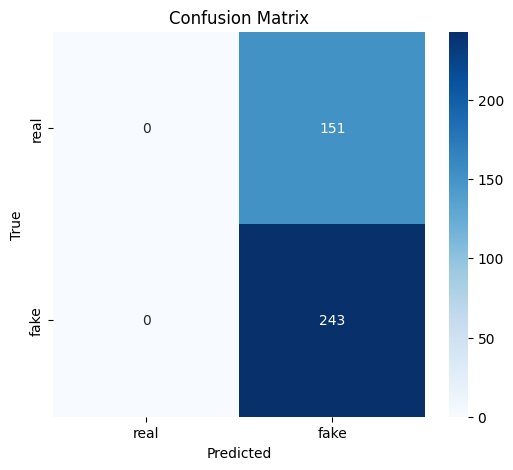

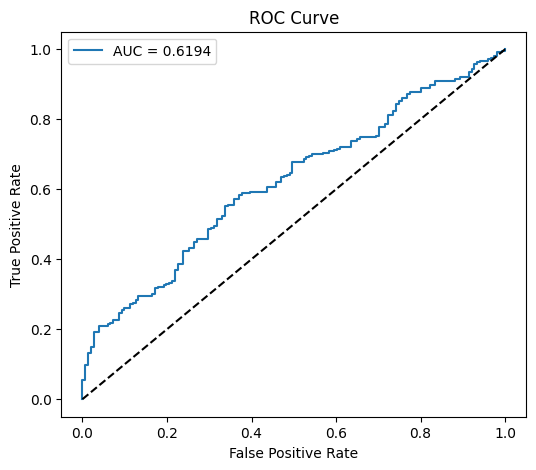

Val   Loss: 0.6598 | Acc: 0.6168 | F1: 0.7630 | Precision: 0.6168 | Recall: 1.0000 | ROC-AUC: 0.6194
Train Loss: 0.6887 | Acc: 0.4630
Val   Loss: 0.6598 | Acc: 0.6168

Epoch 4/10


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Classification Report:

              precision    recall  f1-score   support

        real       0.00      0.00      0.00       151
        fake       0.62      1.00      0.76       243

    accuracy                           0.62       394
   macro avg       0.31      0.50      0.38       394
weighted avg       0.38      0.62      0.47       394

Accuracy: 0.6168
Precision: 0.6168 | Recall: 1.0000 | F1-score: 0.7630
ROC AUC: 0.6315

Confusion Matrix:
 [[  0 151]
 [  0 243]]


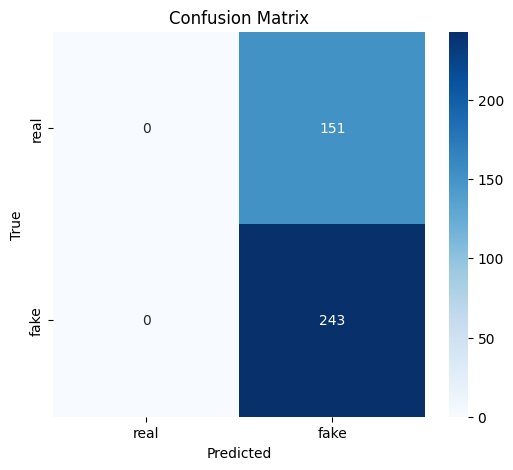

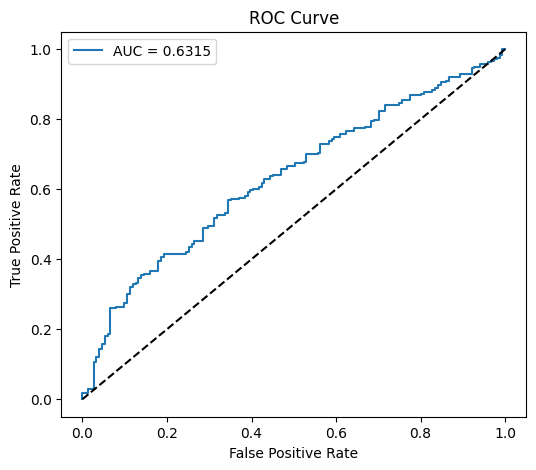

Val   Loss: 0.6493 | Acc: 0.6168 | F1: 0.7630 | Precision: 0.6168 | Recall: 1.0000 | ROC-AUC: 0.6315
Train Loss: 0.6790 | Acc: 0.5125
Val   Loss: 0.6493 | Acc: 0.6168

Epoch 5/10



📊 Classification Report:

              precision    recall  f1-score   support

        real       0.50      0.04      0.07       151
        fake       0.62      0.98      0.76       243

    accuracy                           0.62       394
   macro avg       0.56      0.51      0.42       394
weighted avg       0.57      0.62      0.50       394

Accuracy: 0.6168
Precision: 0.6204 | Recall: 0.9753 | F1-score: 0.7584
ROC AUC: 0.6439

Confusion Matrix:
 [[  6 145]
 [  6 237]]


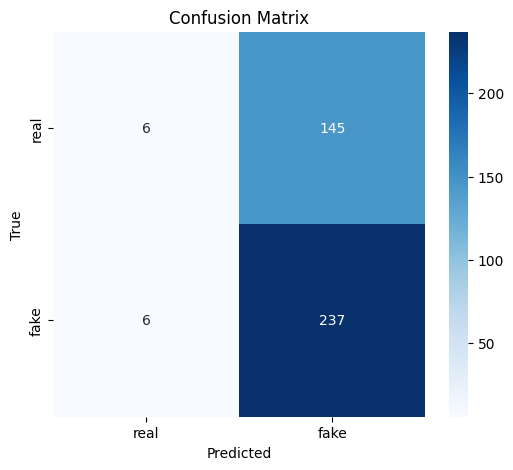

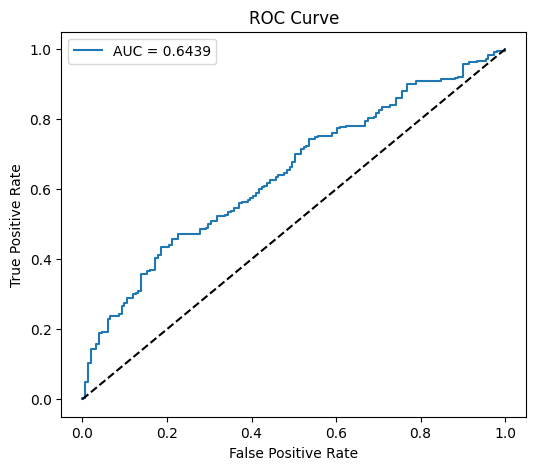

Val   Loss: 0.6369 | Acc: 0.6168 | F1: 0.7584 | Precision: 0.6204 | Recall: 0.9753 | ROC-AUC: 0.6439
Train Loss: 0.6749 | Acc: 0.5255
Val   Loss: 0.6369 | Acc: 0.6168

Epoch 6/10



📊 Classification Report:

              precision    recall  f1-score   support

        real       0.47      0.67      0.55       151
        fake       0.72      0.54      0.62       243

    accuracy                           0.59       394
   macro avg       0.60      0.60      0.59       394
weighted avg       0.63      0.59      0.59       394

Accuracy: 0.5888
Precision: 0.7238 | Recall: 0.5391 | F1-score: 0.6179
ROC AUC: 0.6439

Confusion Matrix:
 [[101  50]
 [112 131]]


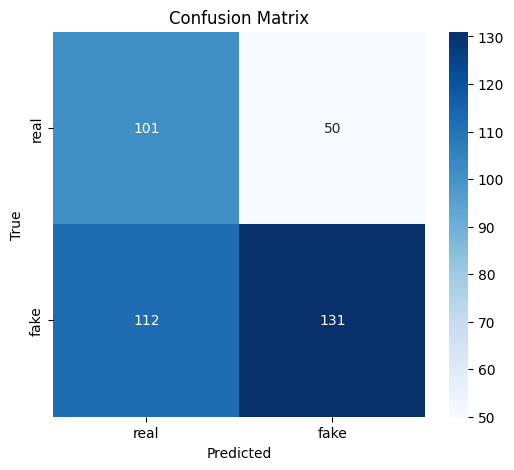

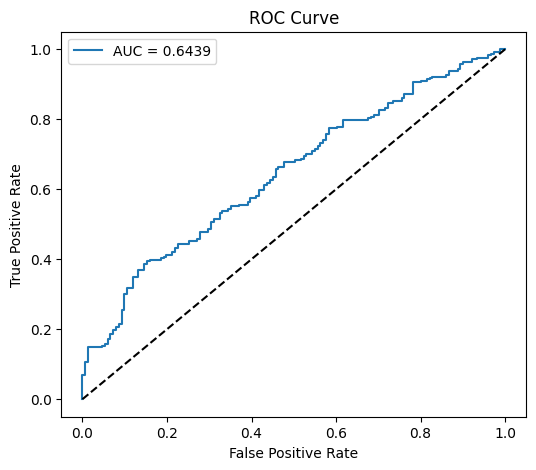

Val   Loss: 0.6607 | Acc: 0.5888 | F1: 0.6179 | Precision: 0.7238 | Recall: 0.5391 | ROC-AUC: 0.6439
Train Loss: 0.6620 | Acc: 0.5516
Val   Loss: 0.6607 | Acc: 0.5888

Epoch 7/10


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Classification Report:

              precision    recall  f1-score   support

        real       0.00      0.00      0.00       151
        fake       0.62      1.00      0.76       243

    accuracy                           0.62       394
   macro avg       0.31      0.50      0.38       394
weighted avg       0.38      0.62      0.47       394

Accuracy: 0.6168
Precision: 0.6168 | Recall: 1.0000 | F1-score: 0.7630
ROC AUC: 0.6615

Confusion Matrix:
 [[  0 151]
 [  0 243]]


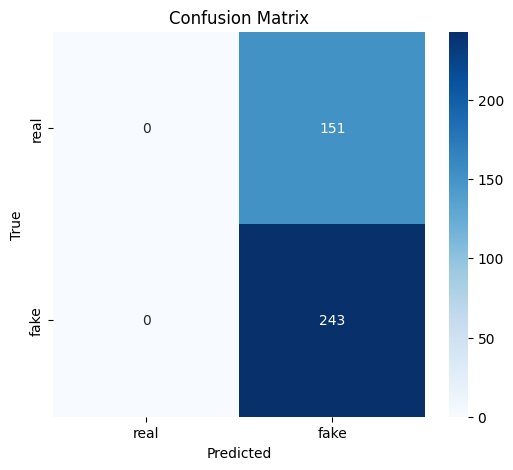

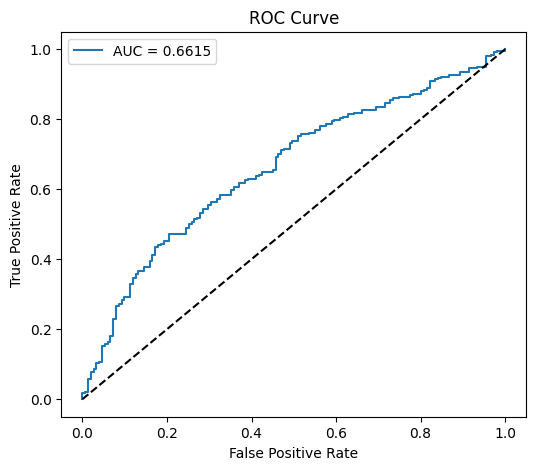

Val   Loss: 0.6564 | Acc: 0.6168 | F1: 0.7630 | Precision: 0.6168 | Recall: 1.0000 | ROC-AUC: 0.6615
Train Loss: 0.6701 | Acc: 0.5109
Val   Loss: 0.6564 | Acc: 0.6168

Epoch 8/10



📊 Classification Report:

              precision    recall  f1-score   support

        real       0.45      0.55      0.50       151
        fake       0.68      0.59      0.63       243

    accuracy                           0.57       394
   macro avg       0.57      0.57      0.56       394
weighted avg       0.59      0.57      0.58       394

Accuracy: 0.5736
Precision: 0.6777 | Recall: 0.5885 | F1-score: 0.6300
ROC AUC: 0.6214

Confusion Matrix:
 [[ 83  68]
 [100 143]]


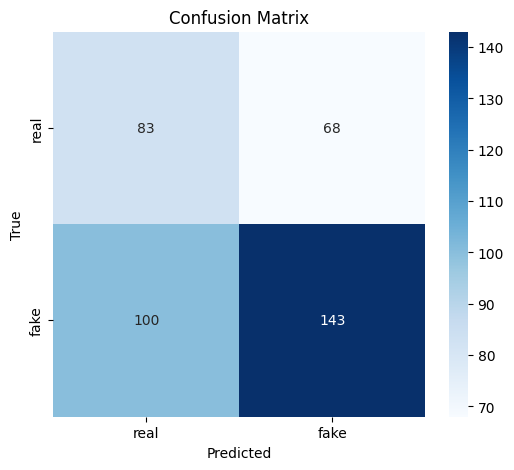

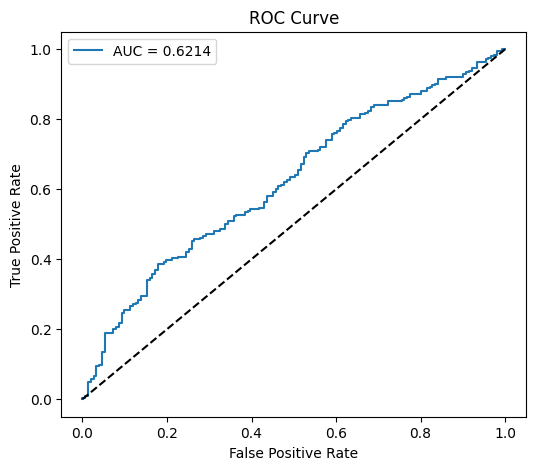

Val   Loss: 0.6617 | Acc: 0.5736 | F1: 0.6300 | Precision: 0.6777 | Recall: 0.5885 | ROC-AUC: 0.6214
Train Loss: 0.6513 | Acc: 0.5755
Val   Loss: 0.6617 | Acc: 0.5736

Epoch 9/10



📊 Classification Report:

              precision    recall  f1-score   support

        real       0.52      0.70      0.60       151
        fake       0.76      0.60      0.67       243

    accuracy                           0.64       394
   macro avg       0.64      0.65      0.64       394
weighted avg       0.67      0.64      0.64       394

Accuracy: 0.6396
Precision: 0.7644 | Recall: 0.6008 | F1-score: 0.6728
ROC AUC: 0.6791

Confusion Matrix:
 [[106  45]
 [ 97 146]]


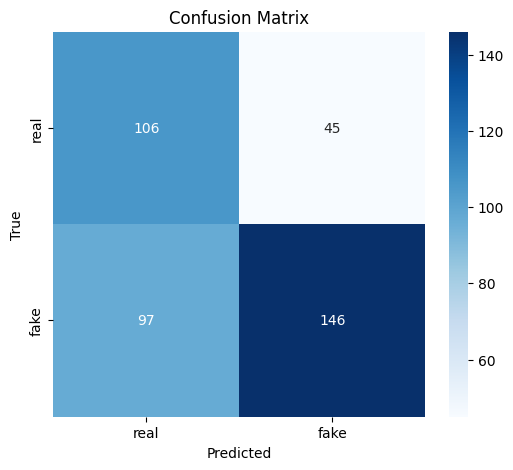

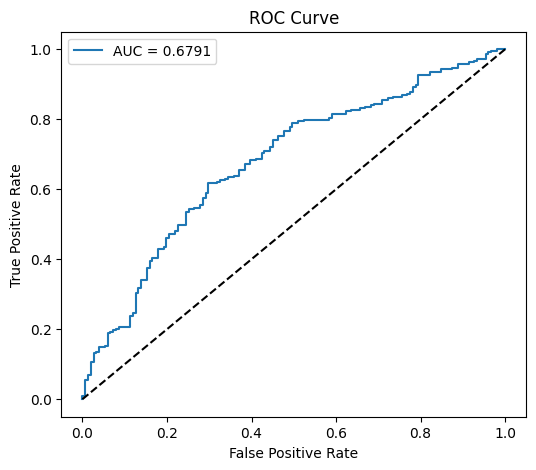

Val   Loss: 0.6394 | Acc: 0.6396 | F1: 0.6728 | Precision: 0.7644 | Recall: 0.6008 | ROC-AUC: 0.6791
Train Loss: 0.6289 | Acc: 0.6152
Val   Loss: 0.6394 | Acc: 0.6396
✅ Model saved: /content/drive/MyDrive/ee604_project/frames_dataset/frames/best_transformer_model.pth

Epoch 10/10



📊 Classification Report:

              precision    recall  f1-score   support

        real       0.50      0.82      0.62       151
        fake       0.82      0.50      0.62       243

    accuracy                           0.62       394
   macro avg       0.66      0.66      0.62       394
weighted avg       0.70      0.62      0.62       394

Accuracy: 0.6218
Precision: 0.8176 | Recall: 0.4979 | F1-score: 0.6189
ROC AUC: 0.6921

Confusion Matrix:
 [[124  27]
 [122 121]]


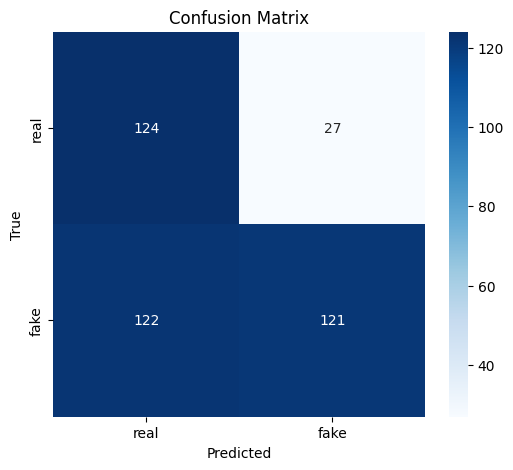

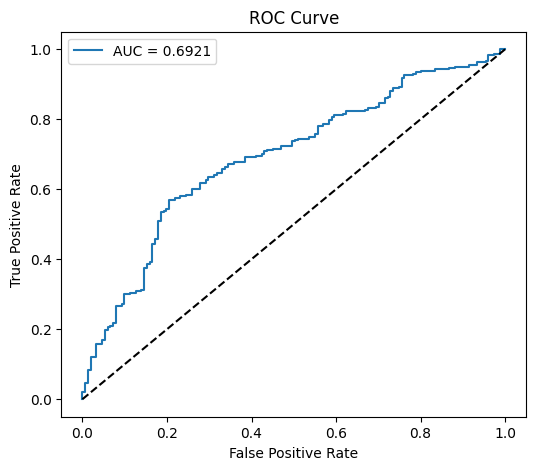

Val   Loss: 0.6525 | Acc: 0.6218 | F1: 0.6189 | Precision: 0.8176 | Recall: 0.4979 | ROC-AUC: 0.6921
Train Loss: 0.6176 | Acc: 0.6359
Val   Loss: 0.6525 | Acc: 0.6218
Training complete. Best Val Acc: 0.6396


In [29]:
# ============================================================
# 8️⃣  Example usage
# ============================================================
model = train_deepfake_detector(
    data_root=data_root,
    epochs=10,
    batch_size=2,
    lr=1e-4,
    frames_per_clip=30
)




📊 Classification Report:

              precision    recall  f1-score   support

        real       0.53      0.79      0.64       157
        fake       0.80      0.55      0.65       238

    accuracy                           0.64       395
   macro avg       0.67      0.67      0.64       395
weighted avg       0.69      0.64      0.64       395

Accuracy: 0.6430
Precision: 0.7975 | Recall: 0.5462 | F1-score: 0.6484
ROC AUC: 0.7305

Confusion Matrix:
 [[124  33]
 [108 130]]


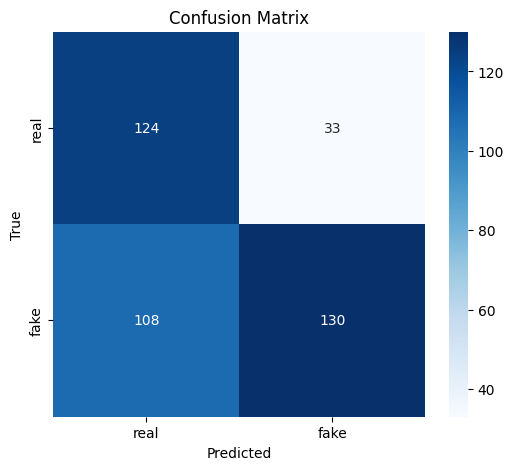

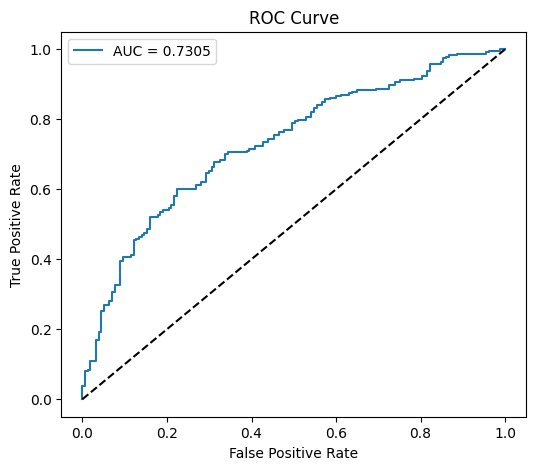


🎯 Final Test Metrics:
Accuracy: 0.6430
Precision: 0.7975 | Recall: 0.5462 | F1-score: 0.6484 | ROC-AUC: 0.7305
Confusion Matrix:
[[124  33]
 [108 130]]


In [31]:
test_loss, test_acc, test_prec, test_rec, test_f1, test_roc, test_cm, test_report = evaluate_full(model, test_loader, criterion, device)
print(f"\n🎯 Final Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_prec:.4f} | Recall: {test_rec:.4f} | F1-score: {test_f1:.4f} | ROC-AUC: {test_roc:.4f}")
print("Confusion Matrix:")
print(test_cm)
with open("test_report.txt", "w") as f:
    f.write(test_report)


In [ ]:
s